# Verifying Word2Vec GPU

Found a GPU implementation of `word2vec` on GitHub. Shout out to the guy's username. Love it.

[https://github.com/whatupbiatch/cuda-word2vec](https://github.com/whatupbiatch/cuda-word2vec)

Specifically, it only implements to Continuous Bag of Words (CBOW) half of word2vec (the other being the Skip-Gram). However, most CUDA implementations so far have been inaccurate / memory constrained. It'd serve us well to verify the results of this GPU implementation.

**Spoilers first: The CUDA code gives inaccurate embeddings**.

But before that, here's why we're doing this.

On a 8 core CPU with 32G of RAM, `gensim`'s implementation of `word2vec` ran at around 20K words per second. The same dataset with the same parameters ran at 400K words per second. This speed up is very sexy.

We'll train a CPU version of the model and a GPU version of the model using the same parameters, and do the following

1. Check their cosine distance for every vocabulary and see that it behaves like that of 2 CPU models
2. Check word similarities to see that the model makes sense

In [1]:
%matplotlib inline
from lib.w2v.w2v import *

In [3]:
cpu_model = model_from_saved("./temp/models-ec2/enron", binary=False)
gpu_model = model_from_saved("./temp/models-gpu/enron", binary=False)

## Cosine Distance

First let's measure the cosine distance between vocabularies.

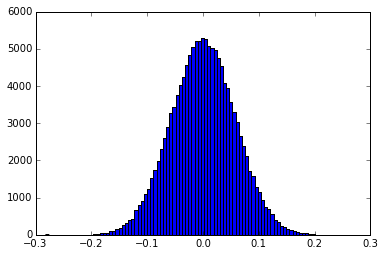

In [15]:
from scipy import spatial

vocabs = {}

for word in cpu_model.vocab:
    if word in cpu_model and word in gpu_model:
        cosine_sim = 1 - spatial.distance.cosine(cpu_model[word], gpu_model[word])
        vocabs[word] = cosine_sim

import matplotlib.pyplot as plot

plot.hist(vocabs.values(), bins=100)
plot.figure()

This distribution looks amazingly similar to the CPU model (found at `vector_rotation_default.ipynb` in this same directory.)

## Word Similarity

Now let's make sure that the embeddings make sense

In [5]:
cpu_model.most_similar('hello')

[(u'hi', 0.6631308794021606),
 (u'hey', 0.572208046913147),
 (u'dear', 0.5451931953430176),
 (u'good_morning', 0.5373660326004028),
 (u'happy_new_year', 0.4551734924316406),
 (u'congratulations', 0.44265079498291016),
 (u'hope', 0.4411052167415619),
 (u'thanks', 0.43363627791404724),
 (u'happy_birthday', 0.41684263944625854),
 (u'doing_well', 0.4160914421081543)]

In [13]:
gpu_model.most_similar('hello')

[(u'playoffs_antowain_smith', 1.0),
 (u'second_guessing', 1.0),
 (u'transmisison', 1.0),
 (u'remains_unchanged', 1.0),
 (u'seoul_korea', 1.0),
 (u'clearly_defined', 1.0),
 (u'correspond', 1.0),
 (u'yds', 1.0),
 (u'steve_leppard', 0.22951051592826843),
 (u'tiverton', 0.22951051592826843)]

Unfortunately, the embeddings don't seem to make too much sense.

For an entire afternoon I thought I had insane GPU gains. Unfortunately, that's a little too good to be true.